In [7]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

features = queries.get_profit_ces_qty_by_week(server, schema)
features.describe().transpose()

count          mean            std            min            25%  \
TYEAR   263.0  2.018023e+03       1.427461    2016.000000    2017.000000   
TWKYR   263.0  2.660837e+01      15.204291       1.000000      13.500000   
PROFIT  263.0  1.077474e+06  227909.239516  436201.360500  921680.520650   
CES     263.0  1.991145e+05   38714.227445   80083.159700  174151.465735   
QTY     263.0  1.733675e+05   35798.248429   70437.374997  149732.206944   

                 50%           75%           max  
TYEAR   2.018000e+03  2.019000e+03  2.021000e+03  
TWKYR   2.700000e+01  4.000000e+01  5.300000e+01  
PROFIT  1.033729e+06  1.219083e+06  1.780968e+06  
CES     1.874135e+05  2.264886e+05  3.141834e+05  
QTY     1.630606e+05  1.956556e+05  2.834409e+05

In [3]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [15]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TWKYR':'WEEK'})
        df['YEAR'] = df['YEAR'].astype(int)
        df['WEEK'] = df['WEEK'].astype(int)
        df['DATE'] = df['YEAR'].astype(str) + '-' +  df['WEEK'].astype(str)
        df = df.drop(columns=['YEAR', 'WEEK'])
        df.set_index('DATE', inplace=True)
        
#         # Insert zeros for missing dates
#         df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        plot_acf(df['QTY'], lags=52)
        plot_pacf(df['QTY'], lags=52)
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        df.plot(subplots=True, title='Added Normalization')
        self.normalized_df = df
        self.scaler = scaler
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
        
    def add_differencing(self, df):
        df = df.diff(52)
        
        return df.dropna()
        
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n/2) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1]
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

#         X_train = train.filter(regex='^(?!' + pred_col + '$)')
        X_train = train.filter(regex='t-')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
#         X_test = test.filter(regex='^(?!' + pred_col + '$)')
        X_test = test.filter(regex='t-')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
    
        X_train, X_test = self.reshape(X_train), self.reshape(X_test)
        
        return X_train, Y_train, X_test, Y_test
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test.values
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
#             scaler = self.scaler
#             df_one = self.train_df
#             df_three = self.test_df
#             expected_df = pd.DataFrame(expected, index=Y_test.index, columns=Y_test.columns)
#             predicted_df = pd.DataFrame(predicted.numpy(), index=Y_test.index, columns=Y_test.columns)
            
#             expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
#             predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
#             full_expected_df = pd.concat(expected_frames)
#             full_predicted_df = pd.concat(predicted_frames)
            
#             inverse_expected = scaler.inverse_transform(full_expected_df)
#             inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
#             indexes = df_one.index.union(expected_df.index).union(df_three.index)      
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
#             print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

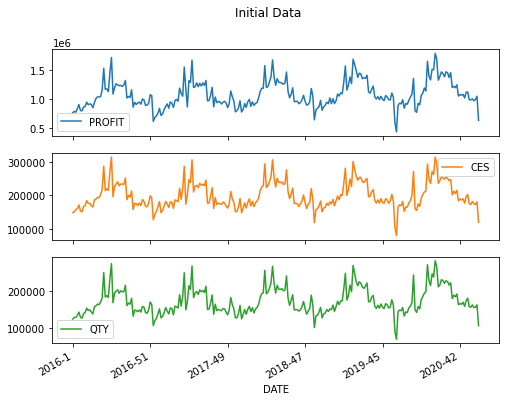

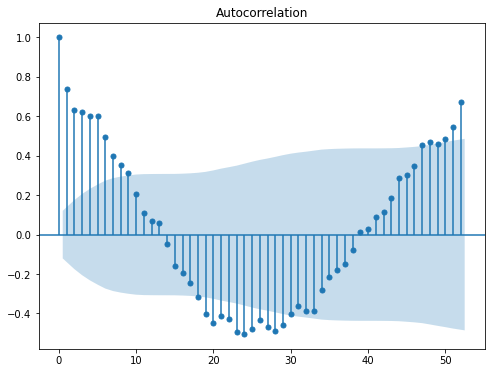

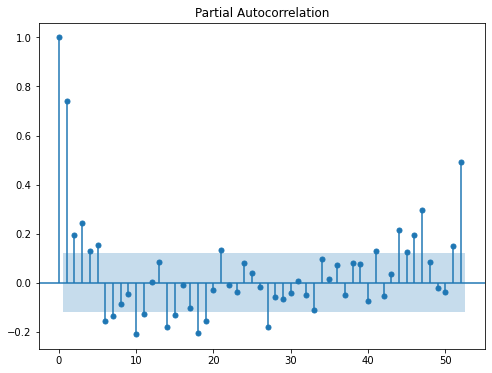

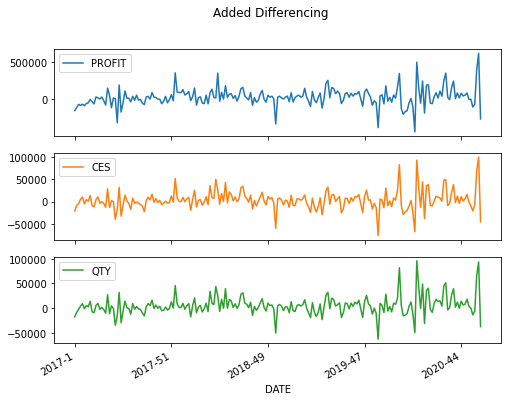

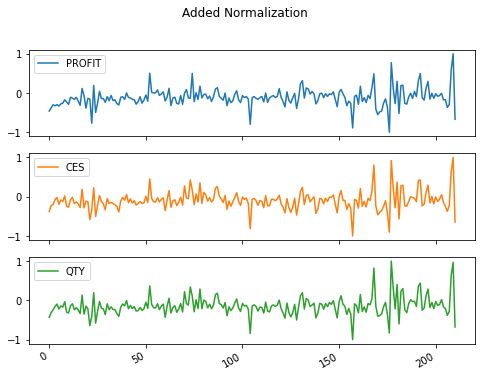

In [16]:
obj = schema_ML(schema, features)

Epoch 1/100
7/7 - 7s - loss: 0.1836 - val_loss: 0.2640
Epoch 2/100
7/7 - 0s - loss: 0.1712 - val_loss: 0.2581
Epoch 3/100
7/7 - 0s - loss: 0.1601 - val_loss: 0.2548
Epoch 4/100
7/7 - 0s - loss: 0.1515 - val_loss: 0.2566
Epoch 5/100
7/7 - 0s - loss: 0.1485 - val_loss: 0.2581
Epoch 6/100
7/7 - 0s - loss: 0.1482 - val_loss: 0.2582
Epoch 7/100
7/7 - 0s - loss: 0.1476 - val_loss: 0.2575
Epoch 8/100
7/7 - 0s - loss: 0.1472 - val_loss: 0.2569


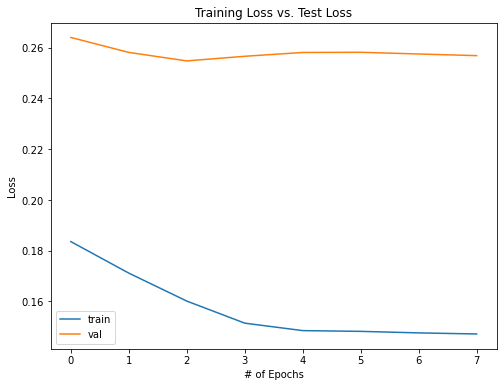

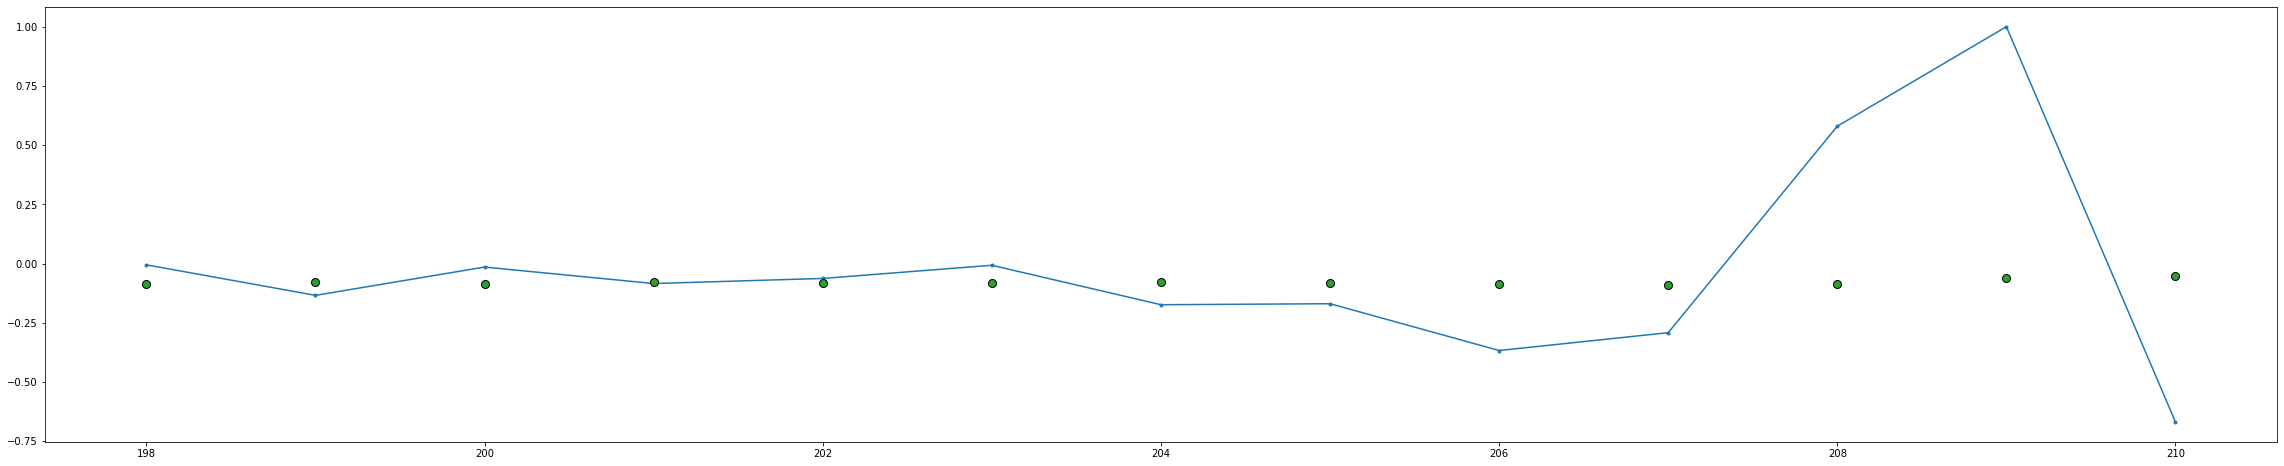

In [18]:
MONITOR = 'val_loss'
PATIENCE = 5
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 100
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0778 - val_loss: 0.0470
Epoch 2/500
52/52 - 0s - loss: 0.0262 - val_loss: 0.0167
Epoch 3/500
52/52 - 0s - loss: 0.0179 - val_loss: 0.0146
Epoch 4/500
52/52 - 0s - loss: 0.0174 - val_loss: 0.0151
Epoch 5/500
52/52 - 0s - loss: 0.0176 - val_loss: 0.0152
Epoch 6/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0141
Epoch 7/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0154
Epoch 8/500
52/52 - 0s - loss: 0.0176 - val_loss: 0.0149
Epoch 9/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0143
Epoch 11/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0155
Epoch 12/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0150
Epoch 13/500
52/52 - 0s - loss: 0.0175 - val_loss: 0.0146
Epoch 14/500
52/52 - 0s - loss: 0.0177 - val_loss: 0.0150
Epoch 15/500
52/52 - 0s - loss: 0.0177 - val_loss: 0.0140
Epoch 16/500
52/52 - 0s - loss: 0.0174 - val_loss: 0.0141
Epoch 17/500
52/52 - 0s - loss: 0.0178 - val_loss: 0.0146
Epoch 18/500
52/52 - 0s

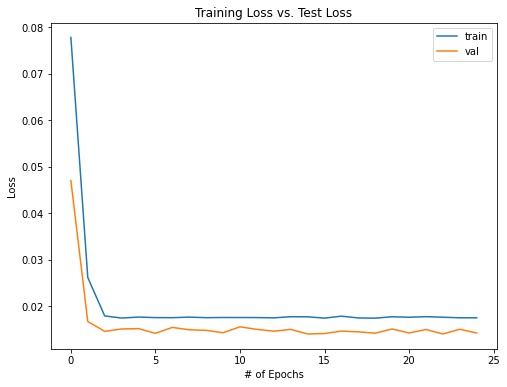

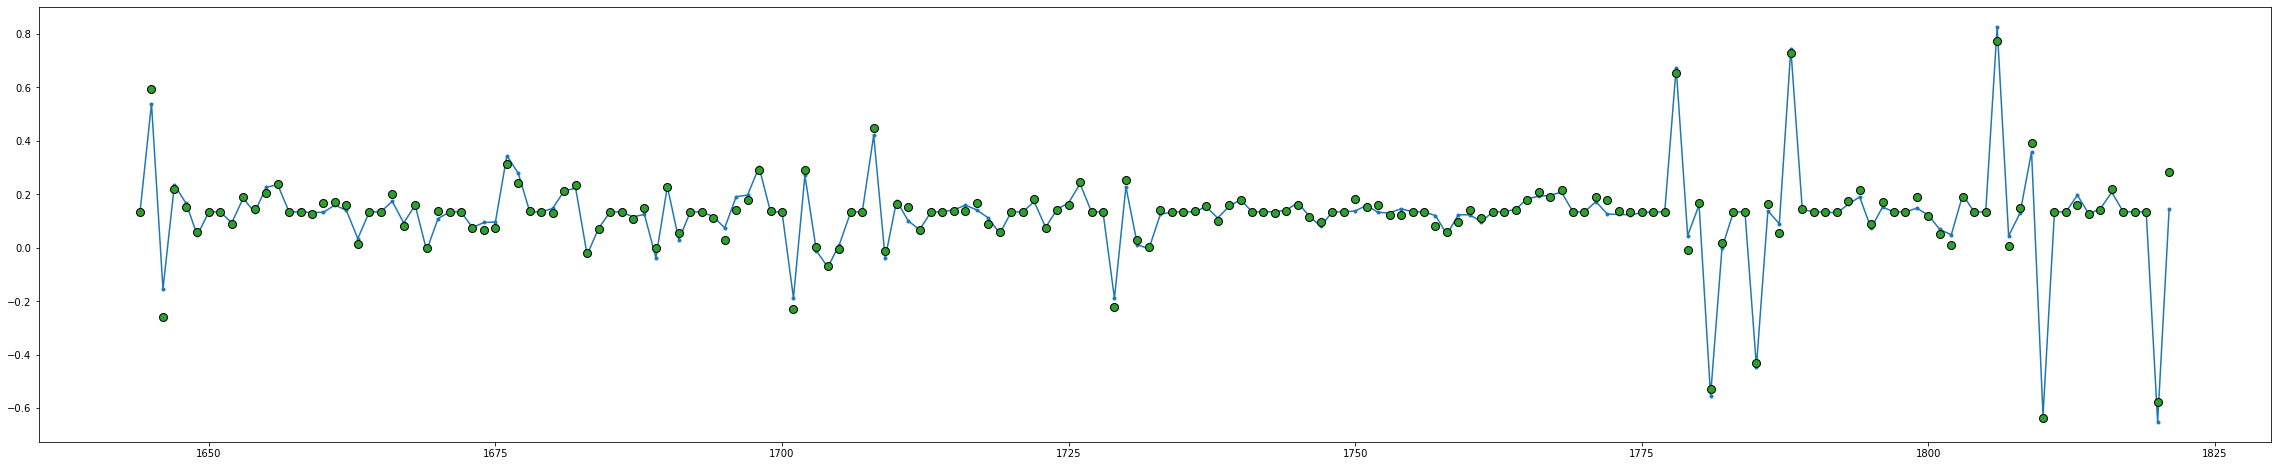

In [9]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_1'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0791 - val_loss: 0.0495
Epoch 2/500
52/52 - 0s - loss: 0.0299 - val_loss: 0.0160
Epoch 3/500
52/52 - 0s - loss: 0.0210 - val_loss: 0.0151
Epoch 4/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0179
Epoch 5/500
52/52 - 0s - loss: 0.0203 - val_loss: 0.0146
Epoch 6/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0151
Epoch 7/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0160
Epoch 8/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0152
Epoch 9/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0194 - val_loss: 0.0148
Epoch 11/500
52/52 - 0s - loss: 0.0187 - val_loss: 0.0159
Epoch 12/500
52/52 - 0s - loss: 0.0184 - val_loss: 0.0149
Epoch 13/500
52/52 - 0s - loss: 0.0190 - val_loss: 0.0158
Epoch 14/500
52/52 - 0s - loss: 0.0189 - val_loss: 0.0146
Epoch 15/500
52/52 - 0s - loss: 0.0185 - val_loss: 0.0149
Epoch 16/500
52/52 - 0s - loss: 0.0186 - val_loss: 0.0142
Epoch 17/500
52/52 - 0s - loss: 0.0188 - val_loss: 0.0148
Epoch 18/500
52/52 - 0s

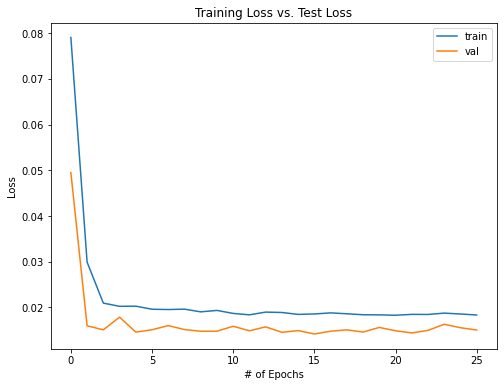

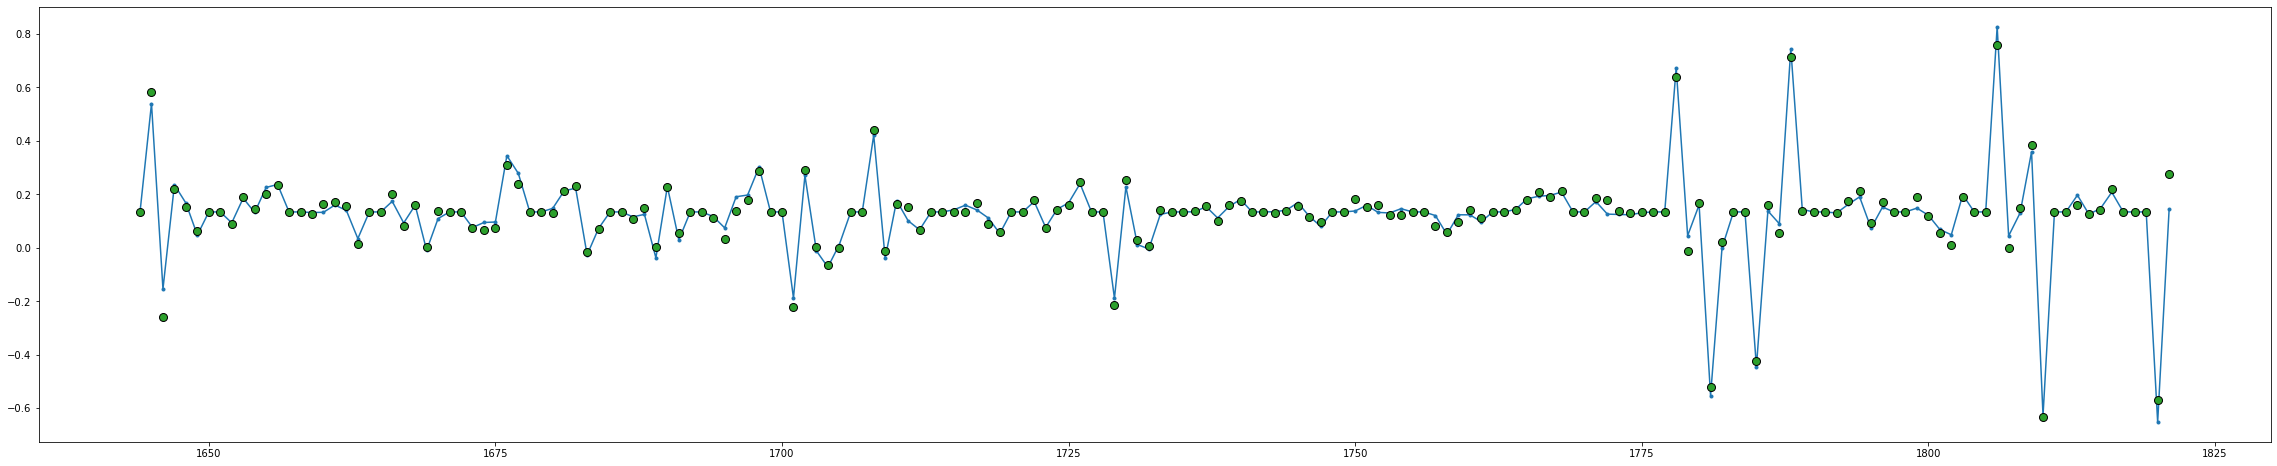

In [10]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_2'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
52/52 - 5s - loss: 0.0815 - val_loss: 0.0550
Epoch 2/500
52/52 - 0s - loss: 0.0356 - val_loss: 0.0176
Epoch 3/500
52/52 - 0s - loss: 0.0240 - val_loss: 0.0149
Epoch 4/500
52/52 - 0s - loss: 0.0232 - val_loss: 0.0159
Epoch 5/500
52/52 - 0s - loss: 0.0220 - val_loss: 0.0163
Epoch 6/500
52/52 - 0s - loss: 0.0218 - val_loss: 0.0157
Epoch 7/500
52/52 - 0s - loss: 0.0223 - val_loss: 0.0162
Epoch 8/500
52/52 - 0s - loss: 0.0225 - val_loss: 0.0152
Epoch 9/500
52/52 - 0s - loss: 0.0214 - val_loss: 0.0148
Epoch 10/500
52/52 - 0s - loss: 0.0220 - val_loss: 0.0152
Epoch 11/500
52/52 - 0s - loss: 0.0208 - val_loss: 0.0152
Epoch 12/500
52/52 - 0s - loss: 0.0202 - val_loss: 0.0146
Epoch 13/500
52/52 - 0s - loss: 0.0213 - val_loss: 0.0154
Epoch 14/500
52/52 - 0s - loss: 0.0207 - val_loss: 0.0147
Epoch 15/500
52/52 - 0s - loss: 0.0201 - val_loss: 0.0158
Epoch 16/500
52/52 - 0s - loss: 0.0205 - val_loss: 0.0148
Epoch 17/500
52/52 - 0s - loss: 0.0202 - val_loss: 0.0146
Epoch 18/500
52/52 - 0s

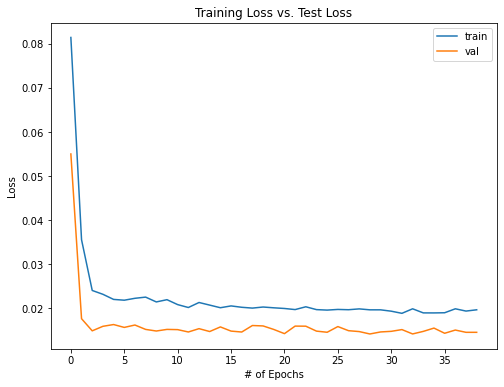

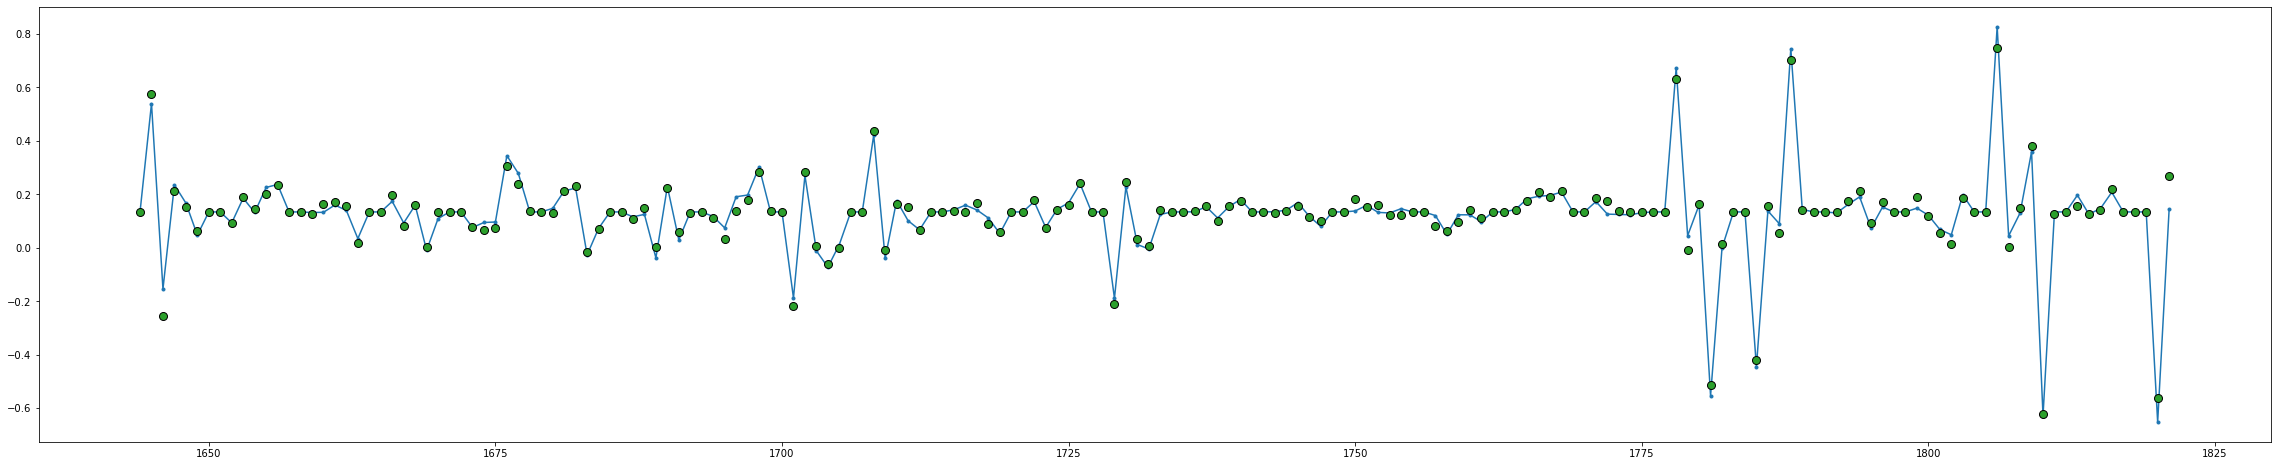

In [11]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

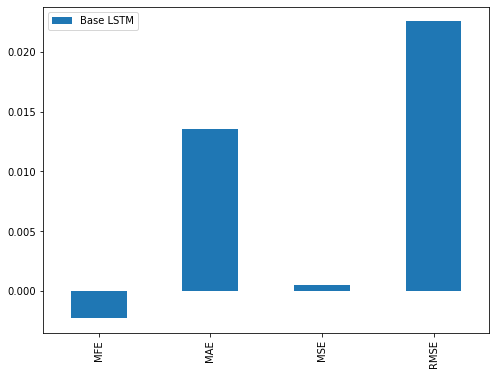

      Base LSTM
MFE   -0.002275
MAE    0.013556
MSE    0.000508
RMSE   0.022544


In [60]:
obj.performance_metrics()